<a href="https://colab.research.google.com/github/pawanaichra/ai61002s19/blob/master/flipkart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
%matplotlib inline
import torch
import os
import tempfile
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
path = "/content/drive/My Drive/"
torch.set_default_tensor_type('torch.DoubleTensor')

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv(path+'flip/training.csv')
train, _ = train_test_split(df, test_size = 13.5/14)
train, test = train_test_split(train, test_size=7/14)
BatchSize = 3

In [0]:
image_set = []
label_set = []
for index, data in train.iterrows():
  path1 = path+'images/'+ data["image_name"]
  if os.path.exists(path1):
    try:
      image = mpimg.imread(path1)
      image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
      image = (image-image.min())/(image.max()-image.min())
      image=image.reshape(1,640, 480)
      labels = np.array([data["x1"], data["y1"], data["x2"], data["y2"]])
      labels=labels.reshape(4)
      image_set.append(image)
      label_set.append(labels)
    except:
      pass
image_set = np.array(image_set)
label_set = np.array(label_set)
inputs=torch.from_numpy(image_set).type(torch.DoubleTensor)
labels=torch.from_numpy(label_set).type(torch.DoubleTensor)
train_set=torch.utils.data.TensorDataset(inputs, labels)
train_set = torch.utils.data.DataLoader(train_set, batch_size=3, shuffle=True, num_workers=2)

In [0]:
# torch.save(inputs, path+"inputs.pt")
# torch.save(labels, path+"labels.pt")

In [0]:
image_set = []
label_set = []
for index, data in test.iterrows():
  path1 = path+'images/'+ data["image_name"]
  if os.path.exists(path1):
    image = mpimg.imread(path1)
    image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    image = (image-image.min())/(image.max()-image.min())
    image=image.reshape(1,640, 480)
    labels = np.array([data["x1"], data["y1"], data["x2"], data["y2"]])
#     labels=labels.reshape(1,4)
    image_set.append(image)
    label_set.append(labels)
image_set = np.array(image_set)
label_set = np.array(label_set)
inputs=torch.from_numpy(image_set).type(torch.DoubleTensor)
labels=torch.from_numpy(label_set).type(torch.DoubleTensor)
test_set=torch.utils.data.TensorDataset(inputs, labels)
test_set = torch.utils.data.DataLoader(test_set, batch_size=BatchSize, shuffle=True, num_workers=4)

In [0]:
#imge size 640*480
class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=3)   
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5)
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride=3) 
        self.fc1 = nn.Linear(5040, 1000)
        self.fc2 = nn.Linear(1000, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)      
        x = x.view(-1, 5040)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        m = torch.tensor([640, 480, 640, 480]).type(torch.DoubleTensor).cuda()
        return x*m
    def sigmoid(self, z):
        return 1/(1+torch.exp(-z))

In [179]:
net = convnet()
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net = net.cuda()

GPU is available!


In [0]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
def iou(box_a, box_b):
  A = box_a.size(0)
  B = box_b.size(0)
  max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
  min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
  inter = torch.clamp((max_xy - min_xy), min=0)
  inter =inter[:, :, 0] * inter[:, :, 1]
  area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)
  area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)
  union = area_a + area_b - inter
  return ((inter / union)*50/float(A)).sum()

def criterion(output, labels):
  return (100-iou(output, labels))
# criterion = nn.MSELoss()


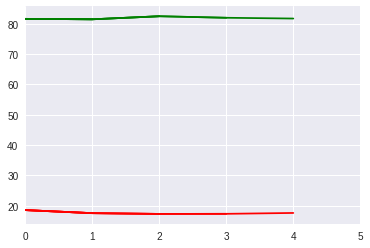

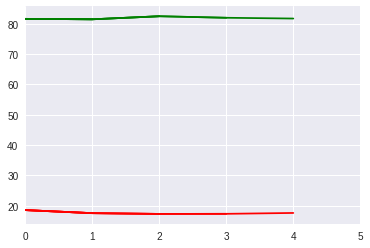

In [194]:
iterations =5
trainLoss = []
testAcc = []

import pylab as pl
from IPython import display
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlim(0,iterations)


for epoch in range(iterations):
    runningLoss = 0 
    count=0
    net.train(True)
    for data in train_set:
      inputs, labels = data
      if use_gpu:
          inputs = Variable(inputs.cuda())
          labels = Variable(labels.cuda())
          labels = labels.cuda()
      else:
          inputs = Variable(inputs)
          labels = Variable(labels) 
      optimizer.zero_grad()   
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      runningLoss += loss.data.item()
      count+=1
#     with tempfile.NamedTemporaryFile(dir = path+"flip/weight/", delete = False) as f:
#       torch.save(net.state_dict(), f)    
    avgTrainLoss = runningLoss/count
    trainLoss.append(avgTrainLoss)
    ax.plot(range(len(trainLoss)),trainLoss,'r-',label='Training')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
    
    with torch.no_grad():
        running_correct = 0
        count1=0
        for data in test_set:
            inputs, labels = data
            if use_gpu:
                inputs = Variable(inputs.cuda()) 
                labels = labels.type(torch.DoubleTensor).cuda()
            else:
                inputs = Variable(inputs)
            outputs = net(inputs)
            running_correct += iou(outputs,labels).item()
            count1+=1
        avgTestAcc = float(running_correct)/count1
        testAcc.append(avgTestAcc)
        ax.plot(range(len(testAcc)),testAcc,'g-',label='Training')
        display.clear_output(wait=True)
        display.display(pl.gcf())
        


In [171]:
avgTestAcc

0.0

In [0]:
predict_set = pd.read_csv(path+'flip/test.csv')
import csv
f = open(path+"flip/out.csv", "w")
writer = csv.writer(f)
row = []
row.append("image_name","x1",	"x2",	"y1",	"y2")
with torch.no_grad():
    for index, data in predict_set.iterrows():
      try:
        path1 = path+'images/'+ data["image_name"]
        image = mpimg.imread(path1)
        image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
        image = (image-image.min())/(image.max()-image.min())
        image=image.reshape(1,1,640, 480)
        inputs=torch.from_numpy(image)
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
        outputs = net(inputs)
        row.append([data["image_name"], outputs[0][0].item(), outputs[0][2].item(), outputs[0][1].item(), outputs[0][3].item()])
      except:
        row.append([data["image_name"], 192, 448, 144, 336])
writer.writerows(row)
f.close()

In [0]:
model=convnet().cuda()
model.load_state_dict(torch.load(path+"flip/weight/tmpyvap3cls"))
model.eval()

convnet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5040, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [0]:
a = torch.tensor([[0, 0, 1, 1],
        [0, 0, 2, 2]]).type(torch.DoubleTensor).cuda()
b = torch.tensor([[0, 0, 2, 2],
        [0, 0, 2, 2]]).type(torch.DoubleTensor).cuda()

def iou(box_a, box_b):
  A = box_a.size(0)
  B = box_b.size(0)
  max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
  min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
  inter = torch.clamp((max_xy - min_xy), min=0)
  inter =inter[:, :, 0] * inter[:, :, 1]
  area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)
  area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)
  union = area_a + area_b - inter
  return ((inter / union)*50).sum()
iou(a,b)

tensor(125., device='cuda:0')

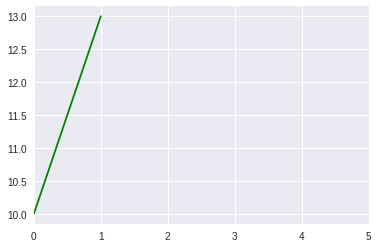

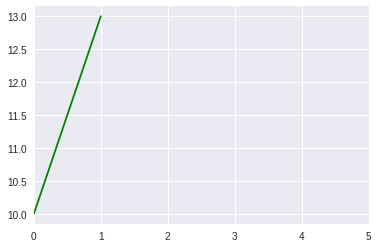

In [192]:


import pylab as pl
from IPython import display
fig=pl.figure(1)
ax=fig.add_subplot(111)
ax.set_xlim(0,iterations)
testAcc = [10,13]
ax.plot(range(len(testAcc)),testAcc,'g-',label='Training')
display.clear_output(wait=True)
display.display(pl.gcf())